# Analyse price 

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

In [2]:
df1 = pd.read_excel('/Users/yann/Downloads/intermodal index pivot chart.xlsx',sheet_name = 'Sheet1')

In [3]:
df1.head(1)

,MMYY,Month,Year,Quarter,Mode,Contract Spot,Origin Region,Origin City,Origin State,Destination City,Destination State,Destination Region,Miles,Value,JBHT
0,2019-07-01,July,2019,Q3,ISI,Contract,Northeast,Allentown,PA,Dallas,TX,Southcentral,1459.0,106.689,JBHT


In [4]:
df = df1.copy()

### Clean data

In [5]:
df.drop(df[df.Year > 2020].index,inplace =True) # remove predictions
df.drop(df[df.Mode == 'ISI'].index,inplace =True)# remove index values

In [6]:
def remove_irrelevant_prices(df):
    mask = [False if isinstance(n,float) else True for n in df.Value] #otherwise df.astype will not work
    df.drop(df[mask].index,inplace=True)
    df['Value'] = df.Value.astype(float)

remove_irrelevant_prices(df)

### Analyse entire dataset

In [7]:
def make_mileage_binned(df, bins):
    df['Miles_interval'] = pd.cut(df.Miles.values, bins)

In [8]:
def plot_price_per_mode(df, bins=5, title='Title'):
    make_mileage_binned(df, bins)
    fig= plt.figure(figsize=(15,3))
    sns.scatterplot(x=df.Value, y=df.Mode, hue=df.Miles_interval, alpha=0.1).set_title(title)

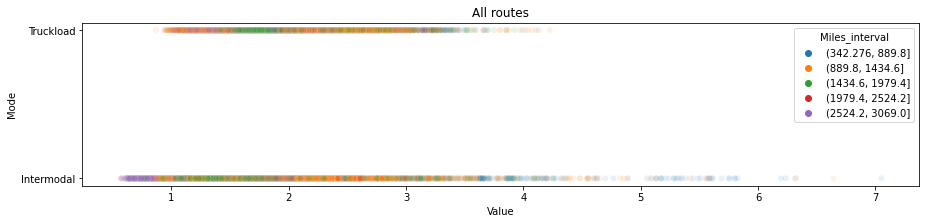

In [9]:
plot_price_per_mode(df,title='All routes')

Intermodal is more volatile than truckload, this is likely to be caused by the drayage segement. The lenght of the drayage will have a large influence on the price

<AxesSubplot:xlabel='Mode', ylabel='Miles'>

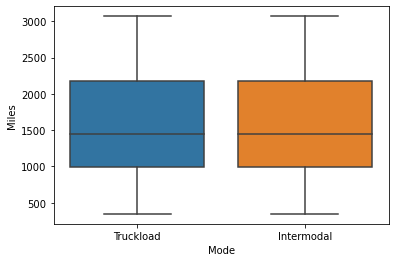

In [10]:
sns.boxplot(x=df.Mode, y=df.Miles)

Two important conclusions can be made from these figures.
* The pricies for Truck and intermodal as set up for the same origin, destination combinations.
* The price is correleated with the distance.

<ipython-input-7-3c124b075337>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Miles_interval'] = pd.cut(df.Miles.values, bins)


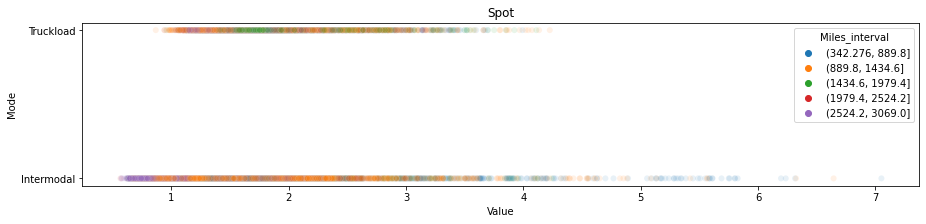

In [11]:
plot_price_per_mode(df[df['Contract Spot'] == 'Spot'],title='Spot')

<ipython-input-7-3c124b075337>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Miles_interval'] = pd.cut(df.Miles.values, bins)


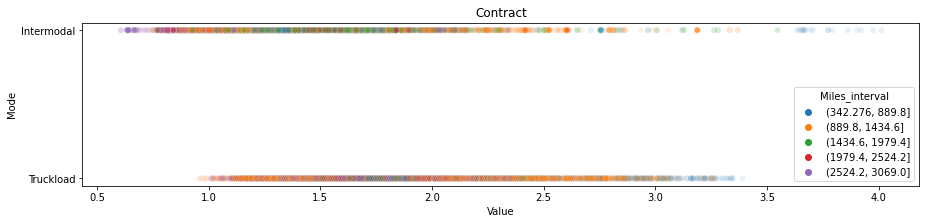

In [12]:
plot_price_per_mode(df[df['Contract Spot'] == 'Contract'],title='Contract')

Spot prices are more volatile. 

# Compute state to state pricing

In [13]:
df_spot = df.copy()
df_spot = df_spot[df_spot['Contract Spot'] == 'Spot']

df_contract = df.copy()
df_contract = df_contract[df_contract['Contract Spot'] == 'Contract']

In [14]:
spot_price = pd.pivot_table(df_spot, values='Value', index=['Origin State', 'Destination State'], columns=['Mode'], aggfunc=np.mean)

contract_price = pd.pivot_table(df_contract, values='Value', index=['Origin State', 'Destination State'], columns=['Mode'], aggfunc=np.mean)

In [15]:
spot_price.fillna(contract_price, inplace=True)

In [16]:
spot_price.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 90 entries, ('AR', 'CA') to ('WA', 'TX')
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Intermodal  89 non-null     float64
 1   Truckload   90 non-null     float64
dtypes: float64(2)
memory usage: 2.0+ KB


In [17]:
pd.set_option('display.max_rows', None)
spot_price.loc[('GA','PA')] = 2.038742 # 848 miles see fallback pricing

In [18]:
spot_price.head()

Mode                            Intermodal  Truckload
Origin State Destination State                       
AR           CA                   1.551846   1.889647
AZ           IL                   1.086138   1.707423
CA           AR                   2.117919   2.257405
             CO                   3.465760   2.858420
             FL                   1.659064   1.844359

# Understand the impact of mileage 
LA -> Chicago is much more expensive than Chicago -> LA

In [19]:
spot_price.loc[('CA','IL')]

Mode
Intermodal    1.301797
Truckload     1.599737
Name: (CA, IL), dtype: float64

In [20]:
spot_price.loc[('IL','CA')]

Mode
Intermodal    1.087140
Truckload     1.561381
Name: (IL, CA), dtype: float64

# Compute fallback price 
As seen before, the best indicator for mileage bang is the distance. A mileage ban based on distance will be computed.

In [21]:
fallback = pd.DataFrame()
fallback['Intermodal'] = df[(df['Contract Spot'] == 'Spot').values & (df['Mode'] == 'Intermodal').values].groupby('Miles_interval').mean().Value
fallback['Truckload'] = df[(df['Contract Spot'] == 'Spot').values & (df['Mode'] == 'Truckload').values].groupby('Miles_interval').mean().Value
fallback

,Intermodal,Truckload
Miles_interval,,
"(342.276, 889.8]",2.038742,1.981305
"(889.8, 1434.6]",1.666665,1.838161
"(1434.6, 1979.4]",1.585102,1.798989
"(1979.4, 2524.2]",1.218652,1.607182
"(2524.2, 3069.0]",1.102274,1.611850


In [22]:
fallback.set_index(pd.Index(['range1','range2','range3','range4','range5']),inplace=True)
fallback

,Intermodal,Truckload
range1,2.038742,1.981305
range2,1.666665,1.838161
range3,1.585102,1.798989
range4,1.218652,1.607182
range5,1.102274,1.611850


In [23]:
spot_price = spot_price.append(fallback)

In [24]:
spot_price.info()

<class 'pandas.core.frame.DataFrame'>
Index: 95 entries, ('AR', 'CA') to range5
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Intermodal  95 non-null     float64
 1   Truckload   95 non-null     float64
dtypes: float64(2)
memory usage: 2.2+ KB


In [26]:
spot_price = round(spot_price,4)

In [27]:
spot_price.to_csv('../../mfreight/Multimodal/data/pricing.csv')

spot_price.to_csv('../../mfreight/Multimodal/data/pricing.csv')# Analyse intermodal

# Vizualize the distribution of the aggregated data we just created 

In [ ]:
pd.read_csv('../../mfreight/Multimodal/data/pricing.csv')

In [17]:
def get_orig_dest_info(df_in, orig_state, dest_state):
    mask_orig_dest = (df['Origin State'] == orig_state).values & (df['Destination State'] == dest_state).values
    df_orig_dest = df_in[mask_orig_dest].copy()
    plot_price_per_mode(df_orig_dest, 4, title=f'{orig_state} to {dest_state} with {len(df_orig_dest)} shipments')
    fig= plt.figure(figsize=(15,3))
    sns.boxplot(x=df_orig_dest.Mode, y=df_orig_dest.Miles)

In [19]:
# for i,j in df3.index.unique():
#     get_orig_dest_info(df, i, j)

In [20]:
df_spot = df.copy()
df_spot = df_spot[df_spot['Contract Spot'] == 'Spot']
df_spot['Value'] = df_spot['Value']/1.61
spot_price = pd.pivot_table(df_spot, values=['Value','Miles'], index=['Origin State', 'Destination State'], columns=['Mode'], aggfunc=np.mean)
counter = pd.pivot_table(df_spot, values='Value', index=['Origin State', 'Destination State'], columns=['Mode'], aggfunc='size')
spot_price['counter'] = counter.Intermodal.fillna(0).values


df_contract = df.copy()
df_contract = df_contract[df_contract['Contract Spot'] == 'Contract']
df_contract['Value'] = df_contract['Value']/1.61
df_contract = pd.pivot_table(df_contract, values=['Value','Miles'], index=['Origin State', 'Destination State'], columns=['Mode'], aggfunc=np.mean)

In [21]:
spot_price.describe()

Miles                   Value                counter
Mode    Intermodal    Truckload Intermodal  Truckload            
count    68.000000    90.000000  66.000000  90.000000   90.000000
mean   1500.760539  1557.531123   0.988826   1.139169   88.555556
std     745.534438   658.182245   0.385660   0.253152   75.949586
min     392.500000   392.500000   0.470754   0.744593    0.000000
25%     897.875000  1001.250000   0.706851   0.963184   67.000000
50%    1210.000000  1577.706328   0.903749   1.117217   68.000000
75%    2131.000000  2017.471053   1.156172   1.263239  136.000000
max    2980.000000  2980.000000   2.573381   1.819696  340.000000

In [22]:
df_contract.describe()

Miles                   Value           
Mode    Intermodal    Truckload Intermodal  Truckload
count    90.000000    69.000000  88.000000  69.000000
mean   1557.285821  1502.336361   0.969086   1.157358
std     658.207018   740.200829   0.342380   0.278223
min     391.142857   392.500000   0.467520   0.739337
25%    1001.250000   913.000000   0.709558   0.972681
50%    1577.714155  1217.000000   0.891521   1.093159
75%    2017.705000  2131.000000   1.134093   1.266234
max    2979.042553  2980.000000   2.335323   1.913371

In [24]:
spot_price.fillna(df_contract, inplace=True)

In [25]:
spot_price.columns  = spot_price.columns.to_flat_index()
spot_price.index  = spot_price.index.to_flat_index()
spot_price['Miles_interval'] = pd.cut(spot_price[('Miles', 'Intermodal')].values, 4)
spot_price['counter_interval'] = pd.cut(spot_price[('counter','')].values, 4)

In [26]:
spot_price.info()

<class 'pandas.core.frame.DataFrame'>
Index: 90 entries, ('AR', 'CA') to ('WA', 'TX')
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   (Miles, Intermodal)  90 non-null     float64 
 1   (Miles, Truckload)   90 non-null     float64 
 2   (Value, Intermodal)  89 non-null     float64 
 3   (Value, Truckload)   90 non-null     float64 
 4   (counter, )          90 non-null     float64 
 5   Miles_interval       90 non-null     category
 6   counter_interval     90 non-null     category
dtypes: category(2), float64(5)
memory usage: 4.8+ KB


Text(0.5, 1.0, 'Aggregated prices')

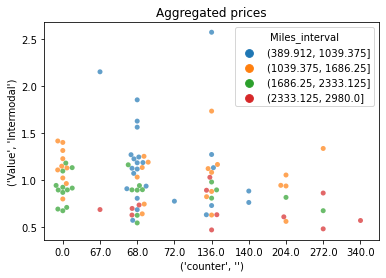

In [27]:
sns.swarmplot(x=spot_price[('counter','')], y=spot_price[('Value', 'Intermodal')],hue=spot_price['Miles_interval'], alpha=0.7).set_title('Aggregated prices')

Text(0.5, 1.0, 'Aggregated prices')

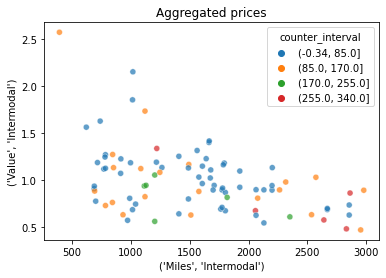

In [28]:
sns.scatterplot(x=spot_price[('Miles', 'Intermodal')], y=spot_price[('Value', 'Intermodal')],hue=spot_price['counter_interval'], alpha=0.7).set_title('Aggregated prices')

Ther is clearly an issue with the mileage for intermodal shipment. Nevertheless the prices seem to be accurate.

# Compute the price for each state combinations

In [32]:
df_spot = df.copy()
df_spot = df_spot[df_spot['Contract Spot'] == 'Spot']

df_contract = df.copy()
df_contract = df_contract[df_contract['Contract Spot'] == 'Contract']

In [33]:
spot_price = pd.pivot_table(df_spot, values='Value', index=['Origin State', 'Destination State'], columns=['Mode'], aggfunc=np.mean)
spot_price.to_csv('../mfreight/Multimodal/data/spot_price.csv')

contract_price = pd.pivot_table(df_contract, values='Value', index=['Origin State', 'Destination State'], columns=['Mode'], aggfunc=np.mean)
contract_price.to_csv('../mfreight/Multimodal/data/contract_price.csv')

In [34]:
import time
start = time.time()
a = pd.read_csv('../mfreight/Multimodal/data/spot_price.csv',index_col=['Origin State','Destination State'])
print(f'time elapsed {time.time()-start}s')

time elapsed 0.0049591064453125s


In [35]:
contract_price

Mode                            Intermodal  Truckload
Origin State Destination State                       
AR           CA                   1.551846        NaN
AZ           IL                   1.086138        NaN
CA           AR                   2.117919        NaN
             CO                   3.187945   2.617091
             FL                   1.651616   2.038636
...                                    ...        ...
WA           CA                   1.084264   1.334755
             GA                   1.086998   1.616500
             IL                   0.915150   1.512269
             NJ                   1.171713   1.877351
             TX                   1.499940   1.645634

[90 rows x 2 columns]

In [36]:
spot_price

Mode                            Intermodal  Truckload
Origin State Destination State                       
AR           CA                        NaN   1.889647
AZ           IL                        NaN   1.707423
CA           AR                        NaN   2.257405
             CO                   3.465760   2.858420
             FL                   1.659064   1.844359
...                                    ...        ...
WA           CA                   1.326884   1.374190
             GA                   1.125522   1.621000
             IL                   1.008160   1.441680
             NJ                   1.184415   1.683924
             TX                   1.517119   1.669230

[90 rows x 2 columns]

In [60]:
spot_price_single_index = spot_price.index.to_flat_index()

In [61]:
spot_price_single_index

Index([('AR', 'CA'), ('AZ', 'IL'), ('CA', 'AR'), ('CA', 'CO'), ('CA', 'FL'),
       ('CA', 'GA'), ('CA', 'IL'), ('CA', 'MA'), ('CA', 'MN'), ('CA', 'MO'),
       ('CA', 'NJ'), ('CA', 'OH'), ('CA', 'TN'), ('CA', 'TX'), ('CA', 'WA'),
       ('CO', 'CA'), ('CO', 'IL'), ('CO', 'PA'), ('CT', 'TX'), ('FL', 'CA'),
       ('FL', 'IL'), ('FL', 'MA'), ('FL', 'NJ'), ('FL', 'TX'), ('GA', 'CA'),
       ('GA', 'FL'), ('GA', 'IL'), ('GA', 'NJ'), ('GA', 'PA'), ('GA', 'TX'),
       ('GA', 'WA'), ('IL', 'AZ'), ('IL', 'CA'), ('IL', 'CO'), ('IL', 'FL'),
       ('IL', 'GA'), ('IL', 'MA'), ('IL', 'NJ'), ('IL', 'OR'), ('IL', 'PA'),
       ('IL', 'TX'), ('IL', 'UT'), ('IL', 'WA'), ('MA', 'CA'), ('MA', 'FL'),
       ('MA', 'IL'), ('MA', 'TX'), ('MD', 'IL'), ('MN', 'CA'), ('MO', 'CA'),
       ('MO', 'OR'), ('NC', 'CA'), ('NC', 'FL'), ('NC', 'IL'), ('NJ', 'CA'),
       ('NJ', 'CO'), ('NJ', 'FL'), ('NJ', 'GA'), ('NJ', 'IL'), ('NJ', 'MO'),
       ('NJ', 'TX'), ('NJ', 'WA'), ('NV', 'TX'), ('NY', 'FL'), ('NY', 'IL'),

In [39]:
# spot_price_single_index = spot_price.set_index(spot_price.index.to_flat_index())

In [40]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df, title="Pandas Profiling Report")

In [27]:
profile

In [1]:
spot_price

NameError: name 'spot_price' is not defined